## 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image, results

In [4]:
def draw_landmarks(images, results):
    mp_drawing.draw_landmarks(images, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(images, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(images, results):
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(images, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    # Draw right hand connections    
    mp_drawing.draw_landmarks(images, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    

## 3. Extract Keypoint Values

In [6]:
def hand_extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

## 4. Setup Folders for Collection

In [7]:
# path ofr exported data, numpy arrays
DATA_PATH = os.path.join('C:/Users/hoya9/Desktop/LSTM_Help/data')

# Actions that we try to detect
actions = np.array(['nothing', 'hand_out', 'fist', 'help'])

# Thirty videos worth of data
no_sequences = 30

# Video are going to be 30 frames in length
sequence_length = 30

In [8]:
# for action in actions:
#     for sequence in range(no_sequences):
#         try:
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

## 6. Preprocess Data and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [10]:
label_map

{'nothing': 0, 'hand_out': 1, 'fist': 2, 'help': 3}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(sequences).shape

(120, 30, 126)

In [13]:
np.array(sequences).shape

(120, 30, 126)

In [14]:
np.array(labels).shape

(120,)

In [15]:
x = np.array(sequences)

In [16]:
x.shape

(120, 30, 126)

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [19]:
x_test.shape, y_test.shape

((24, 30, 126), (24, 4))

## 7. Build and Train LSTM Neural Networkto_categorical

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard

In [22]:
log_dir = os.path.join('Logs_LSTM')
tb_callback = TensorBoard(log_dir=log_dir)

## LSTM

In [21]:
input_shape = Input(shape=(30, 126))
layer = SimpleRNN(64, return_sequences=True, activation='relu')(input_shape)
layer = SimpleRNN(128, return_sequences=True, activation='relu')(layer)
layer = SimpleRNN(64, return_sequences=False, activation='relu')(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dense(32, activation='relu')(layer)
output = Dense(actions.shape[0], activation='softmax')(layer)

## RNN

In [24]:
# input_shape = Input(shape=(20, 126))
# layer = SimpleRNN(64, return_sequences=True, activation='relu')(input_shape)
# layer = SimpleRNN(128, return_sequences=True, activation='relu')(layer)
# layer = SimpleRNN(64, return_sequences=False, activation='relu')(layer)
# layer = Dense(64, activation='relu')(layer)
# layer = Dense(32, activation='relu')(layer)
# output = Dense(actions.shape[0], activation='softmax')(layer)

## ----------------------------------------------------------------

In [22]:
model = Model(input_shape, output, name='LSTM')
model = Model(input_shape, output, name='RNN')

In [23]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 126)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 30, 64)            12224     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 128)           24704     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132     

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-model_RNN.h5')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

In [26]:
history = model.fit(x_train, y_train, epochs=100, callbacks=[checkpoint_cb, early_stopping])

Epoch 1/100
3/3 [==============================] - 0s 40ms/step - loss: 1.3943 - categorical_accuracy: 0.2292
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 1.3302 - categorical_accuracy: 0.3229
Epoch 3/100
3/3 [==============================] - 0s 31ms/step - loss: 1.2862 - categorical_accuracy: 0.5208
Epoch 4/100
3/3 [==============================] - 0s 31ms/step - loss: 1.2338 - categorical_accuracy: 0.5208
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 1.1957 - categorical_accuracy: 0.6042
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 1.0847 - categorical_accuracy: 0.6979
Epoch 7/100
3/3 [==============================] - 0s 36ms/step - loss: 0.9520 - categorical_accuracy: 0.7812
Epoch 8/100
3/3 [==============================] - 0s 32ms/step - loss: 0.8197 - categorical_accuracy: 0.8333
Epoch 9/100
3/3 [==============================] - 0s 47ms/step - loss: 0.6716 - categorical_accuracy: 0.8021
Epoch 10/1

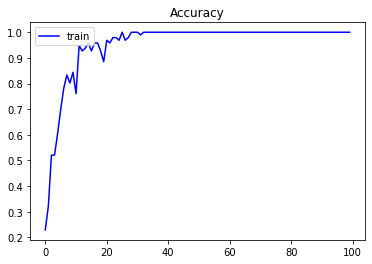

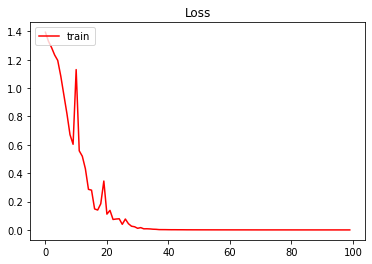

In [27]:
plt.plot(history.history['categorical_accuracy'], 'b')
plt.title('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(history.history['loss'], 'r')
plt.title('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

## 9. Load Weights

In [29]:
model = load_model('C:/Users/hoya9/Desktop/LSTM_Help/best-model_RNN.h5')
# emotion_model = load_model('C:/Users/hoya9/Desktop/Face_Classification/Emotion_little_vgg.h5')

## 8. Make Predictions

In [30]:
res = model.predict(x_test)

In [31]:
actions[np.argmax(res[4])]

'hand_out'

In [32]:
actions[np.argmax(y_test[4])]

'hand_out'

## 10. Evaluation using Confusion Matrix and Accuracy

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [34]:
yhat = model.predict(x_test)

In [35]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [36]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[20,  0],
        [ 0,  4]],

       [[16,  0],
        [ 1,  7]],

       [[17,  1],
        [ 0,  6]],

       [[18,  0],
        [ 0,  6]]], dtype=int64)

In [37]:
accuracy_score(ytrue, yhat)

0.9583333333333334

In [38]:
from sklearn.metrics import precision_score
precision_score(ytrue, yhat, average='micro')

0.9583333333333334

In [39]:
from sklearn.metrics import recall_score
"Recall Score :" , recall_score(ytrue, yhat, average='micro')

('Recall Score :', 0.9583333333333334)

## 11. Test Real Time

In [30]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (0, 255, 255)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame


In [41]:
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = hand_extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 3: 
                sentence = sentence[-3:]
                
            image = cv2.flip(image,1)

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (0, 0, 0), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [42]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
x_test[0].shape

In [ ]:
np.expand_dims(x_test[0], axis=0).shape

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
model.predict(np.expand_dims(x_test[0], axis=0))